# Filtering function
The segmentation routine identifies contiguous regions likely containing ice. We know from experience that it often has flagged regions that are not ice, and can be filtered using clues such as the floe circularity.

The purpose of this notebook is to develop a filtering function with tunable parameters. The main sections here are
1. Compile a list all the test cases with information on (a) whether each stage of IFT completed (b) on whether it's been assigned for floe labeling, and (c) whether the floe labels have been completed.
2. Read in the hdf5 files and true color images
3. Overlay the floe labels on the true color images. These are the "unfiltered" results
4. Filter the labeled images based on a set of thresholds

# 1. Making a list of cases where data is available

In [92]:
import h5py
import pandas as pd
from os.path import join
from os import listdir
import numpy as np
from skimage.measure import regionprops_table
import rasterio as rio
from rasterio.plot import reshape_as_image
import proplot as pplt

caselist_loc = '../data/validation_tables/qualitative_assessment_tables/all_100km_cases.csv'
eval_table_loc = '../data/ift_data/ift_pipeline_default/eval_tables/'
assign_table_loc = '../data/validation_tables/floe_labeling_tables/'
label_floe_loc = '../data/validation_images/labeled_floes_png/'
image_loc = '../data/validation_images/'

df_cases = pd.read_csv(caselist_loc, index_col=0)

# this is to make it easier to link the filenames and case numbers
case_reference = pd.DataFrame({'case_number': df_cases.loc[df_cases.satellite=='aqua', 'case_number'].values,
                               'location': [x[4:] for x in df_cases.loc[df_cases.satellite=='aqua', 'long_name'].values]})

# this has the results on whether IFT ran to completion on each
df_eval = pd.concat([pd.read_csv(eval_table_loc + file) for file in listdir(eval_table_loc) if '.csv' in file])
df_eval['startdate'] = pd.to_datetime(df_eval['startdate'].values)
df_eval.reset_index(inplace=True, drop=True)
df_eval['region'] = [x.split('-100km')[0] for x in df_eval['location']]

# grabbing the assignments here so I know what folder to look in for un-reviewed floe labels
df_assign = pd.concat([pd.read_csv(assign_table_loc + file, index_col=0) for file in listdir(assign_table_loc) if '.csv' in file]) 
df_assign.reset_index(inplace=True, drop=True)

# this adds the case number to the evaluation files and pulls out the columns we need
df_merged = df_eval.merge(case_reference, left_on='location',
                          right_on='location').loc[:,
                                ['region', 'case_number', 'location',
                                 'startdate', 'enddate', 'preprocess', 'tracker']]
# add filenames for relevant images
df_merged['truecolor_aqua'] = ['_'.join([str(cn).zfill(3), region,
                                         '100km', start_date.strftime('%Y%m%d')]) + \
                                   '.aqua.truecolor.250m.tiff' for cn, region, start_date in zip(
                                        df_merged['case_number'],
                                        df_merged['region'],
                                        df_merged['startdate'])]
df_merged['falsecolor_aqua'] = [x.replace('true', 'false') for x in df_merged['truecolor_aqua']]
df_merged['truecolor_terra'] = [x.replace('aqua', 'terra') for x in df_merged['truecolor_aqua']]
df_merged['falsecolor_terra'] = [x.replace('aqua', 'terra') for x in df_merged['falsecolor_aqua']]

# add info on who was assigned the initial floe labeling
df_merged = df_merged.merge(df_assign.loc[:, ['case_number', 'fl_analyst']], left_on='case_number', right_on='case_number', how='outer')

# check if the floe labeling PNG has been created
labeled_floes = listdir(label_floe_loc)
df_merged['aqua_labeled_floes'] = False
df_merged['terra_labeled_floes'] = False
for idx, row in df_merged.iterrows():
    if row['truecolor_aqua'].split('.')[0].replace('_100km', '') + '_aqua_labeled_floes.png' in labeled_floes:
        df_merged.loc[idx, 'aqua_labeled_floes'] = True
    if row['truecolor_terra'].split('.')[0].replace('_100km', '') + '_terra_labeled_floes.png' in labeled_floes:
        df_merged.loc[idx, 'terra_labeled_floes'] = True
df_merged.set_index('case_number', inplace=True)
df_merged.sort_index(inplace=True)

In [93]:
df_temp = df_merged.loc[(df_merged.aqua_labeled_floes==True) | (df_merged.tracker == 'pass'), ['region', 'fl_analyst', 'aqua_labeled_floes', 'terra_labeled_floes']]
print('Number of labeled images:', df_temp.aqua_labeled_floes.sum() + df_temp.terra_labeled_floes.sum())

Number of labeled images: 93


List of images where the tracker ran successfully but there are no labeled images yet:

In [3]:
df_temp.loc[~df_temp.aqua_labeled_floes]

,region,fl_analyst,aqua_labeled_floes,terra_labeled_floes
case_number,,,,
7,baffin_bay,MK,False,False
20,baffin_bay,NaN,False,False
84,barents-kara_seas,NaN,False,False
99,beaufort_sea,EB,False,False
229,chukchi-east_siberian_sea,EB,False,False
263,greenland_sea,EB,False,False
329,hudson_bay,EB,False,False
339,hudson_bay,EB,False,False


# 2. Loading HDF5 files and satellite images
Labeled images are stored in hdf5 files, while the satellite images are GeoTiffs.

In [212]:
experiment = 'ift_pipeline_minarea_100px'
man_loc = '../data/validation_images/labeled_floes_geotiff/'
tc_images = {}
fc_images = {}
floe_properties = {}
labeled_images = {}
manual_images = {}
indices = {}
for case_number in df_merged.loc[df_merged.preprocess=='pass'].index:
    region = df_merged.loc[case_number, 'region']
    case = df_merged.loc[case_number, 'location']
    dataloc = join('../data/ift_data/', experiment, 'ift_results', region, case)
    files = listdir(join(dataloc, 'preprocess', 'hdf5-files'))
    indices[case_number] = {}
    tc_images[case_number] = {}
    fc_images[case_number] = {}
    manual_images[case_number] = {}
    floe_properties[case_number] = {}
    labeled_images[case_number] = {}
    
    for file in files:
        if 'h5' in file:
            if 'icloud' not in file:
                satellite = file.split('.')[1]
                ift_data = h5py.File(join(dataloc, 'preprocess', 'hdf5-files', file))
                indices[case_number]['x'] = ift_data['index']['x'][:]
                indices[case_number]['y'] = ift_data['index']['y'][:]
                # I load the props table here, but there's some issues with it 
                # so we'll re-calculate the props table later for now
                floe_properties[case_number][satellite] = pd.DataFrame(
                    data=ift_data["floe_properties"]["properties"][:].T, # note the transposition
                    columns=ift_data["floe_properties"]["column_names"][:].astype(str))
                labeled_images[case_number][satellite] = ift_data['floe_properties']['labeled_image'][:,:].T # note the transposition
                labeled_images[case_number][satellite] = np.ma.masked_array(
                    labeled_images[case_number][satellite],
                    mask=labeled_images[case_number][satellite]==0)
        else:
            print(case_number, 'no h5')
    if len(files) == 0:
        print(case_number, 'no files')
    for satellite in ['aqua', 'terra']:
        with rio.open(join(image_loc, 'truecolor', df_merged.loc[case_number, 'truecolor_' + satellite])) as im:
            tc_images[case_number][satellite] = im.read()
        with rio.open(join(image_loc, 'falsecolor', df_merged.loc[case_number, 'falsecolor_' + satellite])) as im:
            fc_images[case_number][satellite] = im.read()
        if df_merged.loc[case_number, satellite + '_labeled_floes']:
            with rio.open(join(man_loc, '_'.join(
                [str(case_number).zfill(3), region,
                 df_merged.loc[case_number, 'startdate'].strftime('%Y%m%d'),
                 satellite + '_labeled_floes.tiff']))) as im:
                manual_images[case_number][satellite] = im.read()
                

# 3. Overlay original segementation on images

In [5]:
# Optional: Overlay the labeled image on the true color image
make_plots = False
if make_plots:
    for case_number in labeled_images:
        if 'terra' in labeled_images[case_number]:
            fig, axs = pplt.subplots(width=8, height=4, ncols=2)
            for ax, satellite in zip(axs, ['aqua', 'terra']):
                ax.imshow(reshape_as_image(tc_images[case_number][satellite]))
                ax.imshow(labeled_images[case_number][satellite] % 10, cmap='tokyo')
                ax.format(ltitle=satellite.title())
            axs.format(suptitle='Case ' + str(case_number) + ' (' + df_merged.loc[case_number, 'region'].replace('_', ' ').title() + ')')
            fig.save('../figures/' + experiment + '/overlaid_segmentation/' + str(case_number).zfill(3) + '_segmentation_results.png', dpi=300)
            pplt.close(fig)

Some very obvious errors that should not happen ever:
- Case 32. This one should've been an easy one for the algorithm -- lots of nice, clear floes. Labeled image contains floes that are inside of the land mask.
- Case 20. Not sure what happened here.
- Case 22. Very large segment, likely a cloud, with many holes in it.
- Case 24. Possible case of the land mask being returned as a floe.
    


# 4. Set up filter function

In [6]:
# Advantage of doing this with regionprops_table is that we already use regionprops_table in IFT,
# so there are minimal changes needed to put a filter directly into the code
def threshold_filter(labeled_image,
               truecolor_image,
               falsecolor_image,
               min_area = 100,
               max_area = 90000,
               circ_threshold = 0.65,
               solidity_threshold = 0.85, # Ratio of area to convex area - measure of gaps. 
               tc_intensity_thresholds = (0, 0, 0), # No idea what the best numbers for these are! Also not sure if we want max or min. 0 means the threshold will always be exceeded.
               fc_intensity_thresholds = (0, 0, 0)): 
    """Filter function for use with the labeled image output from Ice Floe Tracker. The function uses the regionprops_table function from 
    scikit-image to compute metrics for labeled objects. Returns a filtered labeled image and a properties table with a columns
    'label', 'area', 'perimeter', 'solidity', 'tc_channel'[0-2], 'fc_channel'[0-2], and flag columns
    'area_flag', 'circularity_flag', 'solidity_flag', 'tc0_flag', 'tc1_flag', 'tc2_flag', 'fc0_flag', 'fc1_flag', 'fc2_flag', 'flagged'.
    The 'flagged' column is set to True if at least one of the flag columns is true. Flagged values failed at least one of the tests.
    """

    # other options: can look at intensity range, potentially also intensity standard deviation
    props = pd.DataFrame(regionprops_table(labeled_image, truecolor_image, properties=['label', 'area', 'perimeter', 'solidity', 'intensity_mean']))
    props_fc = pd.DataFrame(regionprops_table(labeled_image, falsecolor_image, properties=['label', 'intensity_mean']))
    
    props.rename({'intensity_mean-0': 'tc_channel0',
                  'intensity_mean-1': 'tc_channel1',
                  'intensity_mean-2': 'tc_channel2'}, axis=1, inplace=True)
    props_fc.rename({'intensity_mean-0': 'fc_channel0',
                     'intensity_mean-1': 'fc_channel1',
                     'intensity_mean-2': 'fc_channel2'}, axis=1, inplace=True)
    
    props = props.merge(props_fc, left_on='label', right_on='label')
    
    props['circularity'] = 4*np.pi*props['area']/props['perimeter']**2
    
    props['area_flag'] = (props['area'] <= min_area) | (props['area'] >= max_area)
    props['circularity_flag'] = props['circularity'] < circ_threshold
    props['solidity_flag'] = props['solidity'] < solidity_threshold
    for label, thresholds in zip(['tc', 'fc'], [tc_intensity_thresholds, fc_intensity_thresholds]):
        for channel in range(3):
            props[label + str(channel) + '_flag'] = props[label + '_channel' + str(channel)] < thresholds[channel]
    
    all_flags = ['area_flag', 'circularity_flag', 'solidity_flag', 'tc0_flag', 'tc1_flag', 'tc2_flag', 'fc0_flag', 'fc1_flag', 'fc2_flag']
    props['flagged'] = props.loc[:, all_flags].any(axis=1)

    filtered_image = labeled_image.data.copy()
    for label in props.loc[props['flagged'], 'label']:
        filtered_image[filtered_image == label] = 0

    return filtered_image, props

In [144]:
# Setting up logistic filter
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

data = pd.read_csv('../data/ift_data/df_with_tp_classifications.csv')

There is a big issue with the TP/FP training table that needs to get resolved. First step is extracting the case information from the IFT path variable.

In [145]:
def parse_path(ift_path, info_df):
    """Extract case description, number, and satellite from ift_path. Info_df is used to align
    the location description and the case numbers."""
    satellite = ift_path.split('.')[3]
    location = ift_path.split('/')[6]
    case_number = df_merged.loc[df_merged.location == location].index.values[0]
    return satellite, location, case_number

In [146]:
for idx, row in data.iterrows():
    satellite, location, case_number = parse_path(row.ift_path, df_merged)
    data.loc[idx, 'satellite'] = satellite
    data.loc[idx, 'location'] = location
    data.loc[idx, 'case_number'] = str(case_number).zfill(3)

In [67]:
tparams = {'min_area': 100,
           'max_area': 391**2,
           'circ_threshold': 0.55,
           'solidity_threshold': 0.8,
           'tc_intensity_thresholds': (0, 0, 0),
           'fc_intensity_thresholds': (0, 0, 0)}

In [82]:
adjusted_data = []
for case_number in np.unique(data['case_number']):
    for satellite in ['aqua', 'terra']:
        f_im, props_table = threshold_filter(labeled_image=labeled_images[int(case_number)][satellite],
                                     truecolor_image=reshape_as_image(tc_images[int(case_number)][satellite]),
                                     falsecolor_image=reshape_as_image(fc_images[int(case_number)][satellite]),
                                     **tparams)
        props_table['case_number'] = case_number
        props_table['satellite'] = satellite
        
        adjusted_data.append(props_table)
adjusted_data = pd.concat(adjusted_data).reset_index(drop=True)        

In [147]:
adjusted_data['case_id'] = [c + '_' + s for c, s in zip(adjusted_data['case_number'], adjusted_data['satellite'])]
data['case_id'] = [c + '_' + s for c, s in zip(data['case_number'], data['satellite'])]

In [108]:
data_merged = adjusted_data[['case_id', 'area']].merge(data[['case_id', 'area']],
                   left_on='case_id', right_on='case_id', how='inner')

In [161]:
np.unique(data['case_id'])

array(['007_aqua', '007_terra', '016_aqua', '016_terra', '022_aqua',
       '022_terra', '023_aqua', '023_terra', '032_aqua', '032_terra',
       '045_aqua', '045_terra', '081_aqua', '081_terra', '107_aqua',
       '107_terra', '110_aqua', '110_terra', '122_aqua', '122_terra',
       '142_aqua', '142_terra', '146_aqua', '146_terra', '283_aqua',
       '283_terra', '286_aqua', '286_terra', '302_aqua', '302_terra',
       '325_aqua', '325_terra', '362_aqua', '362_terra', '379_aqua',
       '385_aqua', '385_terra'], dtype=object)

In [252]:
case_number = 362
satellite = 'aqua'
test = adjusted_data.loc[(adjusted_data['case_id'] == str(case_number).zfill(3) + '_' + satellite) & (~adjusted_data['flagged'])].merge(
    data.loc[data['case_id'] == str(case_number).zfill(3) + '_' + satellite, ['area', 'solidity', 'tc_channel0', 'tc_channel1', 'TP']], left_on='area', right_on='area')

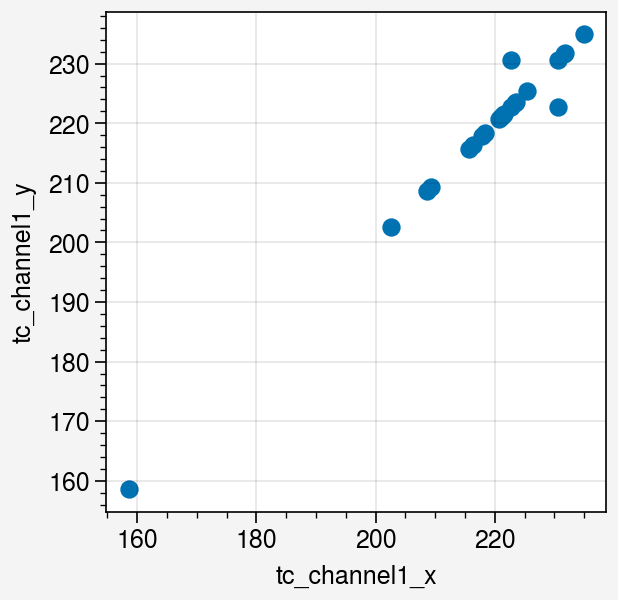

In [253]:
fig, ax = pplt.subplots()
ax.scatter(test['tc_channel1_x'], test['tc_channel1_y'])

In [254]:
test

,label,area,perimeter,solidity_x,tc_channel0_x,tc_channel1_x,tc_channel2,fc_channel0,fc_channel1,fc_channel2,...,fc1_flag,fc2_flag,flagged,case_number,satellite,case_id,solidity_y,tc_channel0_y,tc_channel1_y,TP
0,4,283.0,75.941125,0.829912,222.038869,221.515901,221.777385,164.537102,236.173145,235.749117,...,False,False,False,362,aqua,362_aqua,0.829912,222.038869,221.515901,False
1,6,163.0,45.213203,0.976048,232.085890,230.674847,231.441718,7.061350,238.171779,242.361963,...,False,False,False,362,aqua,362_aqua,0.976048,232.085890,230.674847,True
2,6,163.0,45.213203,0.976048,232.085890,230.674847,231.441718,7.061350,238.171779,242.361963,...,False,False,False,362,aqua,362_aqua,0.910615,223.527607,222.773006,False
3,33,163.0,48.627417,0.910615,223.527607,222.773006,222.067485,168.190184,234.030675,236.036810,...,False,False,False,362,aqua,362_aqua,0.976048,232.085890,230.674847,True
4,33,163.0,48.627417,0.910615,223.527607,222.773006,222.067485,168.190184,234.030675,236.036810,...,False,False,False,362,aqua,362_aqua,0.910615,223.527607,222.773006,False
5,7,105.0,38.870058,0.963303,232.647619,231.580952,230.904762,20.942857,240.180952,241.342857,...,False,False,False,362,aqua,362_aqua,0.963303,232.647619,231.580952,False
6,10,260.0,60.284271,0.942029,232.219231,231.811538,231.180769,28.407692,238.330769,242.353846,...,False,False,False,362,aqua,362_aqua,0.942029,232.219231,231.811538,False
7,11,219.0,56.870058,0.908714,216.415525,216.365297,216.315068,165.899543,231.173516,230.602740,...,False,False,False,362,aqua,362_aqua,0.908714,216.415525,216.365297,False
8,15,191.0,54.384776,0.974490,235.827225,234.900524,233.340314,165.125654,241.434555,243.785340,...,False,False,False,362,aqua,362_aqua,0.974490,235.827225,234.900524,False
9,16,240.0,70.526912,0.805369,224.316667,223.612500,223.300000,169.725000,234.679167,235.804167,...,False,False,False,362,aqua,362_aqua,0.805369,224.316667,223.612500,False


In [238]:
manual_images[case_number][satellite]

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

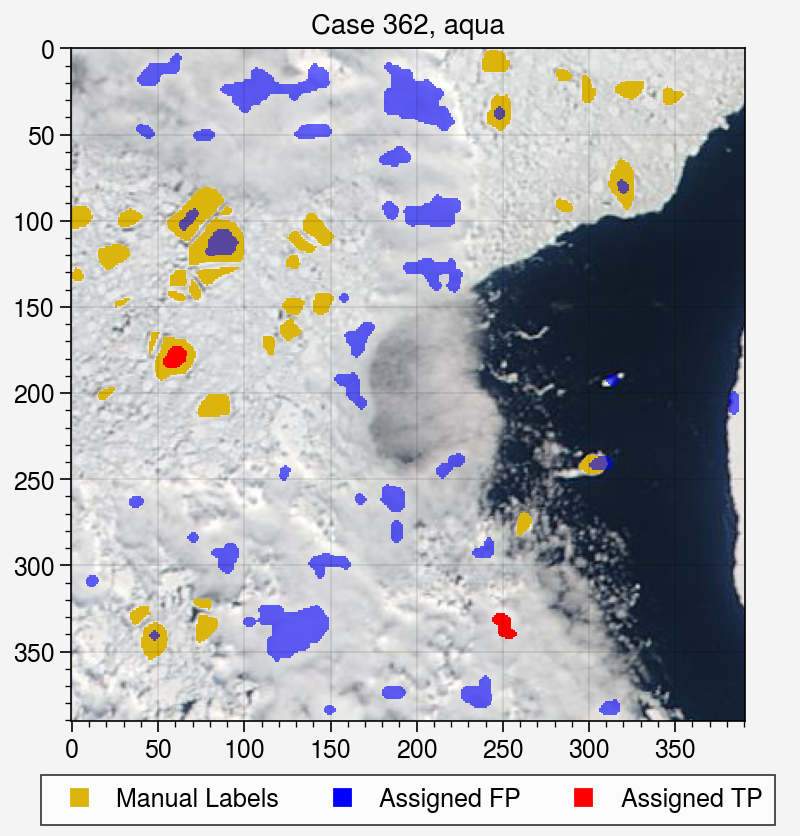

In [257]:
h = []
fig, ax = pplt.subplots(width=4)
ax.imshow(reshape_as_image(tc_images[case_number][satellite]))
ax.imshow(np.ma.masked_array(reshape_as_image(manual_images[case_number][satellite]),
                            mask=reshape_as_image(manual_images[case_number][satellite]==0)),
          c='gold')
ax.imshow(labeled_images[case_number][satellite], alpha=0.6, c='b')
tp_image = labeled_images[case_number][satellite].data
for label in np.unique(tp_image):
    if label in list(test.loc[test.TP, 'label'].values):
        pass
    else:
        tp_image[tp_image == label] = 0
tp_image = np.ma.masked_array(tp_image,
                mask=tp_image==0)        
# tp_image.mask = tp_image != 0
# ax.imshow(labeled_images[case_number][satellite], alpha=0.5, color='b', label='False Positive')
ax.imshow(tp_image, alpha=1, color='r')
ax.legend([ax.plot([],[], marker='s', lw=0, color='gold'),
           ax.plot([],[], marker='s', lw=0, color='b'),
           ax.plot([], [], marker='s', lw=0, color='r')],
          ['Manual Labels',
           'Assigned FP',
           'Assigned TP'], loc='b', ncols=3)
ax.format(title='Case '  + str(case_number).zfill(3) + ', ' + satellite)

In [150]:
# Choose subset of variables
# Correlation between the true color channels is very high, so only one is used
# Similarly, circularity and solidity are highly correlated, so only one is used
variables = ['circularity', # 'solidity',
             'tc_channel0',
#              'tc_channel1', 'tc_channel2',
             'fc_channel0', 'fc_channel1', 'fc_channel2']
# Scale the pixel brightness from 0 to 1
data_scaled = data.copy()
for var in variables:
    if ('tc' in var) | ('fc' in var):
        data_scaled[var] = data_scaled[var]/255
X = data_scaled.loc[:, variables].to_numpy()
y = data_scaled['TP'].to_numpy()

# Split data into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=1/3, random_state=10)

# Fit the logistic regression model using cross validation
lr_model = LogisticRegressionCV(Cs=10,
                     solver='lbfgs',
                     scoring='accuracy',
                     penalty='l2',
                     cv=10,
                     random_state=5).fit(X_train, y_train)

In [160]:
print('LR model fit using accuracy metric: ', np.round(lr_model.score(X_test, y_test), 2))

LR model fit using accuracy metric:  0.81


Checking that variables are in right order in model...

In [151]:
# Images to run: only the ones where IFT ran successfully
def lr_filter(labeled_image, truecolor_image, falsecolor_image, lr_model, variables):
    """Applies a logistic regression model to the image.  lr_model
    is the object returned by LogisticRegressionCV. Variables is the list
    of variables used to set up the model.
    Returns same props matrix as the threshold filter, as well as the "true positive confidence".
    This last variable is negative for false positives, positive for true positives, and the larger
    the value, the more confidence the model has.
    """

    # make the properties table
    props = pd.DataFrame(regionprops_table(labeled_image, truecolor_image, properties=['label', 'area', 'perimeter', 'solidity', 'intensity_mean']))
    props_fc = pd.DataFrame(regionprops_table(labeled_image, falsecolor_image, properties=['label', 'intensity_mean']))
    
    props.rename({'intensity_mean-0': 'tc_channel0',
                  'intensity_mean-1': 'tc_channel1',
                  'intensity_mean-2': 'tc_channel2'}, axis=1, inplace=True)
    props_fc.rename({'intensity_mean-0': 'fc_channel0',
                     'intensity_mean-1': 'fc_channel1',
                     'intensity_mean-2': 'fc_channel2'}, axis=1, inplace=True)
    
    props = props.merge(props_fc, left_on='label', right_on='label')
    
    props['circularity'] = 4*np.pi*props['area']/props['perimeter']**2
        
    # scale the intensities
    props_scaled = props.copy()
    for var in props_scaled.columns:
        if ('tc_' in var) | ('fc_' in var):
            props_scaled[var] = props_scaled[var]/255
    
    X = props_scaled.loc[:, variables].to_numpy()
    
    props['flagged'] = ~lr_model.predict(X) # Model gives True for true positives, we flip that so the flag means bad data
    props['true_positive_confidence'] = lr_model.decision_function(X)
    
    filtered_image = labeled_image.data.copy()
    for label in props.loc[props['flagged'], 'label']:
        filtered_image[filtered_image == label] = 0

    return filtered_image, props    

In [152]:
from skimage.io import imsave
from skimage import img_as_uint
save_loc = '../data/ift_filtered/'
results_tables = {}
for case_number in labeled_images:
    results_tables[case_number] = {}
    for satellite in labeled_images[case_number]:
        labeled_im = labeled_images[case_number][satellite].copy()
        tc_im = reshape_as_image(tc_images[case_number][satellite])
        fc_im = reshape_as_image(fc_images[case_number][satellite])

        # Unchanged image, full dataframe
        no_filter_im, no_props = threshold_filter(labeled_im, tc_im, fc_im, circ_threshold=0,
                                            solidity_threshold=0, min_area=0, max_area=1e10)
        
        # Too small and too large floes removed
        # Dataframe has all floes, but includes column for flagged floes.
        area_filter_im, area_props = threshold_filter(labeled_im, tc_im, fc_im,
                                                circ_threshold=0, solidity_threshold=0, min_area=100, max_area=90e3)
        
        # In addition to area filter, only retains flows with high enough
        # circularity and solidity
        thresh_filter_im, thresh_props = threshold_filter(labeled_im, tc_im, fc_im, circ_threshold=0.55, solidity_threshold=0.85)
        
        # Alternate approach using logistic regression model
        # Only can apply this if there is at least one detected floe
        if len(no_props) > 0:
            lr_filter_im, lr_props = lr_filter(labeled_im, tc_im, fc_im, lr_model,
                                               variables=['circularity', 'tc_channel0', 'fc_channel0', 'fc_channel1', 'fc_channel2'])

            keep = ['label', 'area', 'perimeter', 'circularity',  'solidity',
            'tc_channel0', 'tc_channel1', 'tc_channel2',
            'fc_channel0', 'fc_channel1', 'fc_channel2', 'flagged']
            thresh_props = thresh_props.loc[:, keep].rename({'flagged': 'threshold_flag'}, axis=1)
            area_props = area_props.loc[:, keep].rename({'flagged': 'area_flag'}, axis=1)
            lr_props = lr_props.loc[:, keep + ['true_positive_confidence']].rename({'flagged': 'lr_flag'}, axis=1)
            props = area_props.merge(thresh_props[['label', 'threshold_flag']], left_on='label', right_on='label')
            results_tables[case_number][satellite] = props.merge(lr_props[['label', 'true_positive_confidence', 'lr_flag']], left_on='label', right_on='label')

In [153]:
for case_number in results_tables:
    for satellite in results_tables[case_number]:
        df = results_tables[case_number][satellite]
        print(case_number, satellite, len(df), df['area_flag'].sum(), df['threshold_flag'].sum(), df['lr_flag'].sum())

7 aqua 28 15 16 28
7 terra 28 15 17 27
16 terra 26 11 18 17
16 aqua 22 7 15 17
20 aqua 4 1 3 4
20 terra 4 1 4 4
22 aqua 5 0 4 5
22 terra 4 1 2 4
23 terra 45 17 25 43
23 aqua 51 23 29 47
24 terra 6 2 3 6
24 aqua 8 2 2 5
32 aqua 4 1 3 4
32 terra 10 4 7 10
45 aqua 51 15 19 21
45 terra 63 20 24 32
81 aqua 16 4 7 16
81 terra 6 3 5 6
84 terra 18 4 12 18
84 aqua 21 7 15 21
98 terra 37 15 25 32
98 aqua 40 15 23 39
99 terra 41 8 17 40
99 aqua 42 10 22 42
107 aqua 32 18 24 29
107 terra 38 14 20 38
110 terra 31 11 20 25
110 aqua 34 7 18 30
119 aqua 18 11 11 18
119 terra 21 9 12 21
122 terra 20 10 10 20
122 aqua 20 10 10 20
132 terra 8 5 7 8
132 aqua 12 5 6 12
142 aqua 17 9 10 8
142 terra 19 11 12 7
146 aqua 49 19 30 45
146 terra 51 17 27 42
176 aqua 21 13 15 21
176 terra 22 13 13 22
178 aqua 34 10 19 33
178 terra 22 6 9 22
228 terra 13 3 6 11
228 aqua 10 4 5 8
229 terra 58 29 34 35
229 aqua 49 18 24 28
263 terra 42 12 16 32
263 aqua 41 10 15 29
283 terra 1 0 1 1
283 aqua 1 0 1 1
286 aqua 36 11 18

In [259]:
results_tables[7]['aqua']

,label,area,perimeter,circularity,solidity,tc_channel0,tc_channel1,tc_channel2,fc_channel0,fc_channel1,fc_channel2,area_flag,threshold_flag,true_positive_confidence,lr_flag
0,1,204.0,56.041631,0.816241,0.940092,229.019608,228.838235,227.132353,173.700980,236.254902,239.975490,False,False,-2.215653,True
1,2,44.0,21.313708,1.217151,1.000000,229.022727,228.136364,227.431818,174.590909,237.113636,240.863636,True,True,-0.852037,True
2,3,65.0,26.727922,1.143386,1.000000,232.261538,231.261538,228.307692,83.538462,237.661538,240.569231,True,True,-0.029899,True
3,4,724.0,119.053824,0.641892,0.910692,229.490331,228.883978,226.968232,164.563536,235.410221,241.156077,False,False,-2.673975,True
4,5,1706.0,175.095454,0.699261,0.912788,231.556272,231.259086,229.276084,172.311841,236.960727,241.211606,False,False,-2.519658,True
5,6,329.0,73.941125,0.756195,0.921569,230.544073,229.939210,227.866261,40.899696,233.468085,241.905775,False,False,-0.907030,True
6,7,44.0,21.313708,1.217151,1.000000,225.772727,224.772727,222.772727,171.750000,237.000000,239.545455,True,True,-0.871162,True
7,8,37.0,19.313708,1.246465,1.000000,225.594595,224.594595,222.594595,174.729730,236.459459,239.054054,True,True,-0.840561,True
8,9,155.0,47.455844,0.864893,0.922619,223.761290,224.167742,221.567742,166.458065,232.470968,236.309677,False,False,-2.211406,True
9,10,143.0,43.213203,0.962306,0.953333,226.132867,226.223776,222.300699,171.797203,235.986014,239.020979,False,False,-1.757093,True


In [93]:
# This section is for saving the images to disk. Better would be to make an hdf5 file that has the images in it.        
# Saving in case necessary.
#         for im, df, name in zip([no_filter_im, area_filter_im, thresh_filter_im],
#                                 [area_props, thresh_props],
#                                 ['no_filter', 'area_filter', 'threshold_filter'],
#                                 ):
#             fname = '_'.join([str(case_number).zfill(3), df_merged.loc[case_number, 'region'], satellite, name])
#             imsave(save_loc + 'filtered_images/' + name + '/'  + fname + '.png', img_as_uint(im), check_contrast=False)
#             df.to_csv(save_loc + 'filtered_tables/' + name + '/' + fname + '.csv')
#         break

In [120]:
keep = ['label', 'area', 'perimeter', 'circularity',  'solidity',
        'tc_channel0', 'tc_channel1', 'tc_channel2',
        'fc_channel0', 'fc_channel1', 'fc_channel2', 'flagged']
thresh_props = thresh_props.loc[:, keep].rename({'flagged': 'threshold_flag'}, axis=1)
area_props = area_props.loc[:, keep].rename({'flagged': 'area_flag'}, axis=1)
lr_props = lr_props.loc[:, keep + ['true_positive_confidence']].rename({'flagged': 'lr_flag'}, axis=1)
props = area_props.merge(thresh_props[['label', 'threshold_flag']], left_on='label', right_on='label')
props = props.merge(lr_props[['label', 'true_positive_confidence', 'lr_flag']], left_on='label', right_on='label')

KeyError: "['flagged'] not in index"

In [105]:
props

,label,area,perimeter,circularity,solidity,tc_channel0,tc_channel1,tc_channel2,fc_channel0,fc_channel1,fc_channel2,area_flag,threshold_flag,true_positive_confidence,lr_flag
0,1,312.0,72.769553,0.740398,0.936937,226.769231,226.769231,225.910256,170.544872,235.375000,238.862179,False,False,-4.331116,True
1,2,62.0,26.142136,1.140038,1.000000,222.548387,222.548387,222.548387,154.064516,231.112903,237.064516,True,True,-3.224582,True
2,3,178.0,51.455844,0.844813,0.956989,227.235955,227.235955,226.606742,167.820225,234.702247,239.483146,False,False,-4.039709,True
3,4,44.0,21.313708,1.217151,1.000000,233.886364,233.886364,233.886364,156.363636,238.204545,242.363636,True,True,-2.979354,True
4,5,57.0,24.727922,1.171411,1.000000,230.543860,229.543860,226.631579,17.473684,235.596491,240.842105,True,True,-5.208287,True
5,6,213.0,57.112698,0.820586,0.938326,223.352113,223.525822,221.201878,169.422535,232.854460,236.737089,False,False,-4.058886,True
6,7,1737.0,173.923882,0.721591,0.916623,228.636154,229.554404,228.900403,162.338515,233.796776,240.353483,False,False,-4.584205,True
7,8,684.0,110.811183,0.700001,0.929348,229.697368,229.111111,227.073099,157.659357,235.859649,240.723684,False,False,-4.705893,True
8,9,361.0,93.597980,0.517826,0.811236,229.831025,229.501385,226.941828,103.783934,234.698061,240.853186,False,True,-6.158504,True
9,10,44.0,21.313708,1.217151,1.000000,222.090909,222.090909,222.090909,166.136364,231.954545,235.863636,True,True,-2.746181,True


In [46]:
! ls ../data/ift_filtered/filtered_tables/no_filter

In [40]:
/Users/dwatkin2/Documents/research/manuscripts/cal-val_ice_floe_tracker/ift_cal-val/data/ift_filtered/filtered_tables

NameError: name 'Users' is not defined

Example of running the filter

I've loaded the images into dictionaries. Rasterio uses a different order for image dimensions than does scikit, so I use the `reshape_as_image` function to reformat them. 
You'll note that the props table that comes back has the mean values for different parameters. If we are careful to separate testing and training data, we can set up optimization routines to use the mean values for true positives to identify the appropriate thresholds for the truecolor and falsecolor channels.

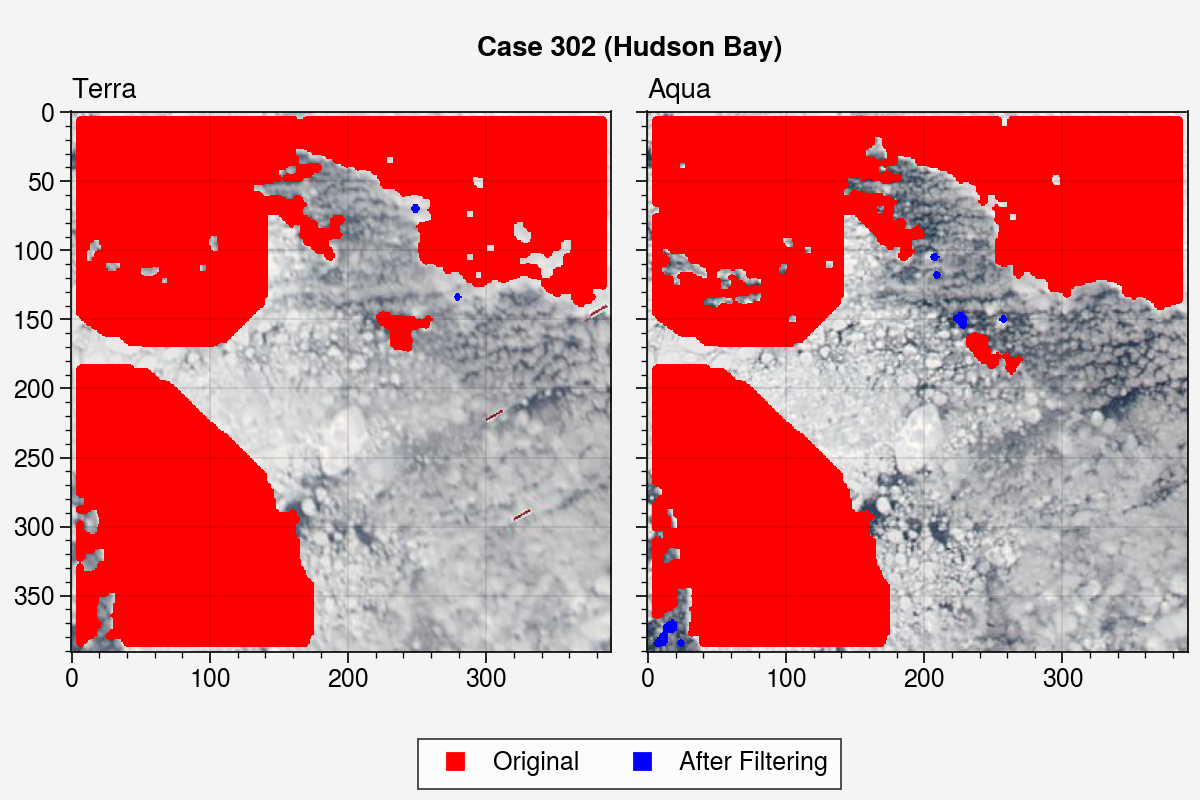

In [8]:
case_number = 302

fig, axs = pplt.subplots(width=6, height=4, ncols=2)
for ax, satellite in zip(axs, ['terra', 'aqua']):

    labeled_im = labeled_images[case_number][satellite].copy()
    tc_im = reshape_as_image(tc_images[case_number][satellite])
    fc_im = reshape_as_image(fc_images[case_number][satellite])
    filtered_im, props = ift_filter(labeled_im, tc_im, fc_im,
                                    circ_threshold = 0.6,
                                    solidity_threshold = 0.8)
     
    ax.imshow(reshape_as_image(tc_images[case_number][satellite]))
    ax.imshow(labeled_images[case_number][satellite], color='r')
    ax.imshow(np.ma.masked_array(filtered_im, filtered_im==0), color='b')
    ax.format(ltitle=satellite.title())
h = [ax.plot([],[], marker='s', lw=0, color=c) for c in ['r', 'b']]
l = ['Original', 'After Filtering']
fig.legend(h, l, loc='b', ncols=2)
axs.format(suptitle='Case ' + str(case_number) + ' (' + df_merged.loc[case_number, 'region'].replace('_', ' ').title() + ')')
